## Project Code - 202211388

## "Sentiment Analysis of Tweets on the Ukraine-Russia War"

## Importing Libraries

In [1]:
# Install required packages
!pip install tensorflow
!pip install langdetect

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')  #for word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from textblob import TextBlob



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset

In [2]:
#loading dataset
data = pd.read_excel('Project_Data.xlsx')

#Display the first 5 rows 
data.head(5)

,User,Username,UTC Date,Tweet,Binders,Permalink,Retweet count,Likes count,Tweet value
0,OG Liberty Ninja,@theasianlibert2,2023-01-11 22:41:35,"@elonmusk @slashdot As long as the Govt., uses...",NaN,https://www.twitter.com/user/status/1613305148...,0,0,0.00
1,KB 🇺🇸,@BlackKyler,2023-01-11 22:41:36,@GDarkconrad Must be a Russian sub in Lake Sup...,NaN,https://www.twitter.com/user/status/1613305153...,0,0,0.13
2,Blog Boi,@YoungLionBlog,2023-01-11 22:41:36,@pissoffluvv You gotta just crop off the top. ...,NaN,https://www.twitter.com/user/status/1613305152...,0,1,1.27
3,Kiara,@Kiaraki09,2023-01-11 22:41:36,I can sit in my house all day in peace ❤️,NaN,https://www.twitter.com/user/status/1613305152...,0,0,0.43
4,Peter Edwards,@PeterEd38924140,2023-01-11 22:41:36,@Biz_Ukraine_Mag The picture made me smile; th...,NaN,https://www.twitter.com/user/status/1613305151...,0,0,0.01


## Data Pre-processing

In [3]:
#Checking for missing values
data.isnull().sum()


User                 52
Username              0
UTC Date              0
Tweet                 0
Binders          300361
Permalink             0
Retweet count         0
Likes count           0
Tweet value           0
dtype: int64

In [4]:
#removing all the columns except Tweet because that is the main focus
data = data.drop(['User', 'Username', 'UTC Date', 'Binders', 'Permalink', 'Retweet count', 'Likes count', 'Tweet value'], axis=1)

#Display the first 5 rows 
data.head(5)

,Tweet
0,"@elonmusk @slashdot As long as the Govt., uses..."
1,@GDarkconrad Must be a Russian sub in Lake Sup...
2,@pissoffluvv You gotta just crop off the top. ...
3,I can sit in my house all day in peace ❤️
4,@Biz_Ukraine_Mag The picture made me smile; th...


## Cleaning

In [5]:
# Function to filter out tweets that are not English language
def filter_languages(tweet):
    try:
        lang = detect(tweet)
        allowed_languages = ['en']
        return lang in allowed_languages
    except:
        return False

# Apply the language filter to the DataFrame
data_filtered = data[data['Tweet'].apply(filter_languages)]

data_filtered.head(5)

,Tweet
0,"@elonmusk @slashdot As long as the Govt., uses..."
1,@GDarkconrad Must be a Russian sub in Lake Sup...
2,@pissoffluvv You gotta just crop off the top. ...
3,I can sit in my house all day in peace ❤️
4,@Biz_Ukraine_Mag The picture made me smile; th...


In [6]:
 # Remove all occurrences of the specified pattern from the input text
def remove_pattern(input_txt, pattern):     
    r = re.findall(pattern, input_txt)     
    for i in r:         
        input_txt = re.sub(i, '', input_txt)              
    return input_txt

In [7]:
# remove twitter handles (@user) 
data_filtered['cleaned_tweet'] = np.vectorize(remove_pattern)(data_filtered['Tweet'], "@[\w]*")

C:\Users\samue\AppData\Local\Temp\ipykernel_4992\78269764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['cleaned_tweet'] = np.vectorize(remove_pattern)(data_filtered['Tweet'], "@[\w]*")


In [8]:
# Function to remove URLs, mentions, hashtags, and special characters
def remove_special_characters(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove special characters
    return text.strip()

# Function to lowercase the text
def lowercase(text):
    return text.lower()

# Function to tokenize the text and remove stop words
def tokenize_and_remove_stopwords(text):
    additional_stopwords = ['trending', 'nan', 'der', 'la', 'ha', 'qui', 'el', 'les', 'ist', 'da', 'su', 'mit', 'di', 'de', 'en', 'amp','rt']
    stop_words = set(stopwords.words('english') + additional_stopwords)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Function for stemming
def stem_text(text):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stemmed_words)

# Function for lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)





In [9]:
import string
# Apply preprocessing steps one by one
data_filtered['cleaned_text'] = data_filtered['cleaned_tweet'].apply(remove_special_characters)
data_filtered['cleaned_text'] = data_filtered['cleaned_text'].apply(lowercase)
data_filtered['cleaned_text'] = data_filtered['cleaned_text'].apply(tokenize_and_remove_stopwords)
data_filtered['cleaned_text'] = data_filtered['cleaned_text'].apply(lemmatize_text)





C:\Users\samue\AppData\Local\Temp\ipykernel_4992\2546268043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['cleaned_text'] = data_filtered['cleaned_tweet'].apply(remove_special_characters)
C:\Users\samue\AppData\Local\Temp\ipykernel_4992\2546268043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['cleaned_text'] = data_filtered['cleaned_text'].apply(lowercase)
C:\Users\samue\AppData\Local\Temp\ipykernel_4992\2546268043.py:5: SettingWithCopyWarning: 
A value is trying to b

## TextBlob Sentiment Analysis

In [10]:
# Create a function to assign sentiment labels using TextBlob
def get_sentiment(text):
    if isinstance(text, float):
        text = str(text)
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Apply the sentiment function to the 'Text' column and create the 'Sentiment' column
data_filtered['Sentiment'] = data_filtered['cleaned_text'].apply(get_sentiment)


C:\Users\samue\AppData\Local\Temp\ipykernel_4992\3627845855.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Sentiment'] = data_filtered['cleaned_text'].apply(get_sentiment)


In [11]:
data_filtred = data_filtered[['cleaned_text', 'Sentiment']]
data_filtered.head(5)

,Tweet,cleaned_tweet,cleaned_text,Sentiment
0,"@elonmusk @slashdot As long as the Govt., uses...","As long as the Govt., uses the money of US T...",long govt us money u taxpayer pay death shot d...,positive
1,@GDarkconrad Must be a Russian sub in Lake Sup...,Must be a Russian sub in Lake Superior,must russian sub lake superior,positive
2,@pissoffluvv You gotta just crop off the top. ...,You gotta just crop off the top. I started do...,got ta crop top started known much peace life,positive
3,I can sit in my house all day in peace ❤️,I can sit in my house all day in peace ❤️,sit house day peace ❤️,neutral
4,@Biz_Ukraine_Mag The picture made me smile; th...,The picture made me smile; the resilience of ...,picture made smile resilience youth thankyou,positive


## Data Visualization

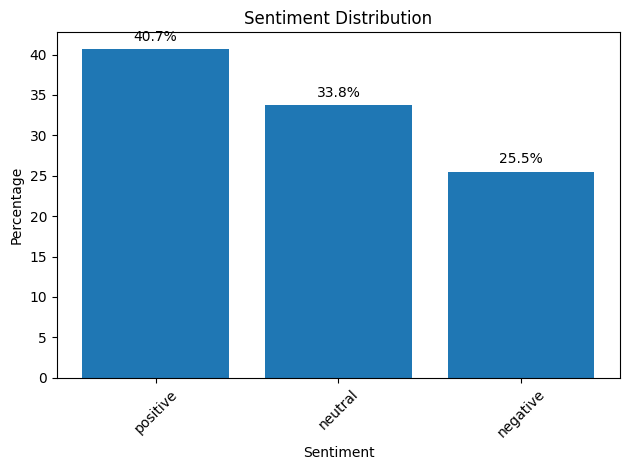

In [12]:

# Count the frequency of each sentiment label
sentiment_counts = data_filtered['Sentiment'].value_counts()

# Calculate the total count
total_count = sentiment_counts.sum()

# Calculate the percentage of each sentiment
sentiment_percentages = (sentiment_counts / total_count) * 100

# Create a bar plot with percentage labels
plt.bar(sentiment_percentages.index, sentiment_percentages.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=45)  # Rotate x-labels for better visibility

for i, percentage in enumerate(sentiment_percentages):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center')
plt.tight_layout()
plt.show()


In [13]:
# Count the frequency of each sentiment label
sentiment_counts = data_filtered['Sentiment'].value_counts()

sentiment_counts

positive    120420
neutral      99903
negative     75481
Name: Sentiment, dtype: int64

In [14]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the cleaned text data to obtain the document-term matrix
dtm = vectorizer.fit_transform(data_filtered['cleaned_text'])

# Get the vocabulary
vocabulary = vectorizer.get_feature_names_out()


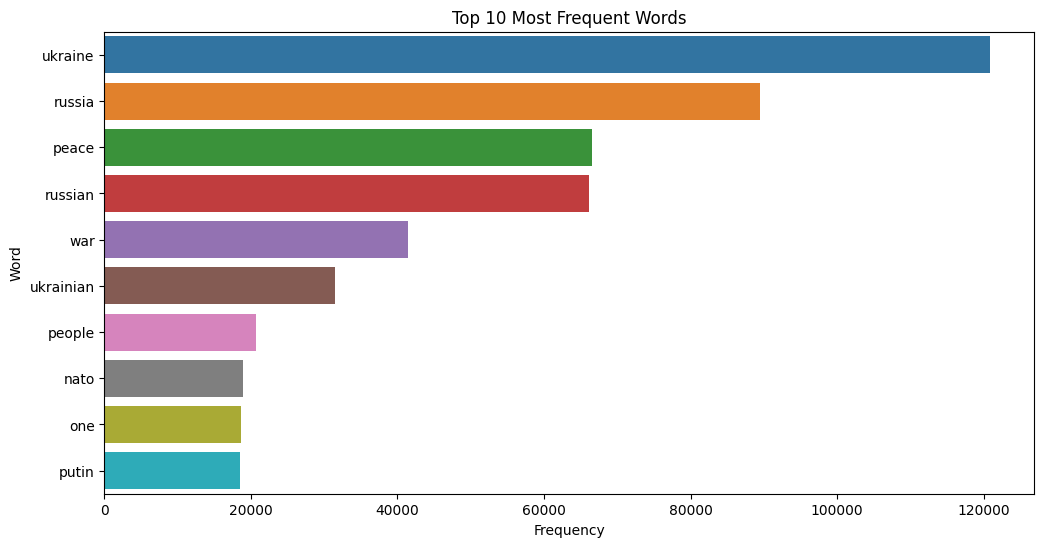

In [15]:
# Calculate the word frequencies
word_frequencies = np.asarray(dtm.sum(axis=0)).ravel()

# Create a dataframe with words and their frequencies
word_freq_df = pd.DataFrame({'Word': vocabulary, 'Frequency': word_frequencies})

# Sort the dataframe by word frequencies in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Plot the top 10 most frequent words
top_n = 10
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(top_n))
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()



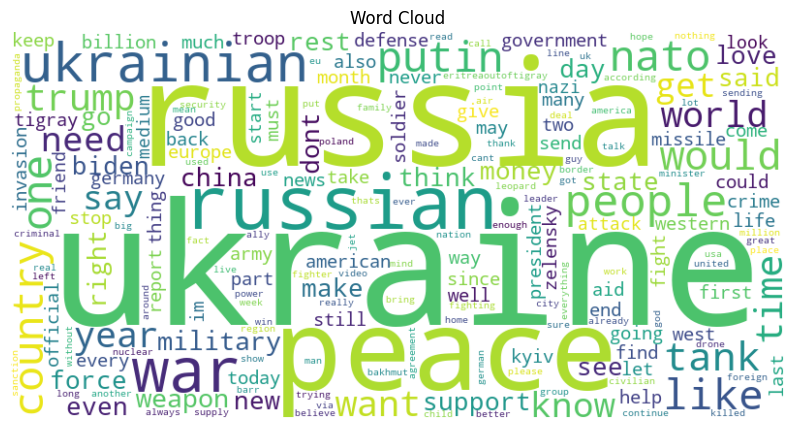

In [16]:
from wordcloud import WordCloud

# Convert the word frequencies into a dictionary
word_freq_dict = dict(zip(word_freq_df['Word'], word_freq_df['Frequency']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()

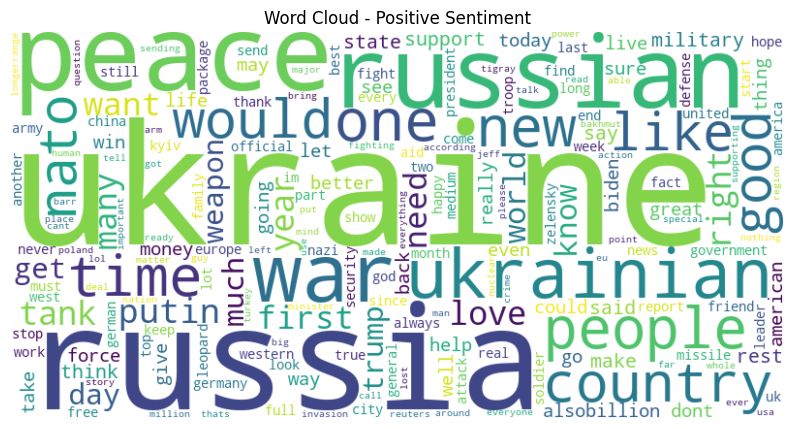

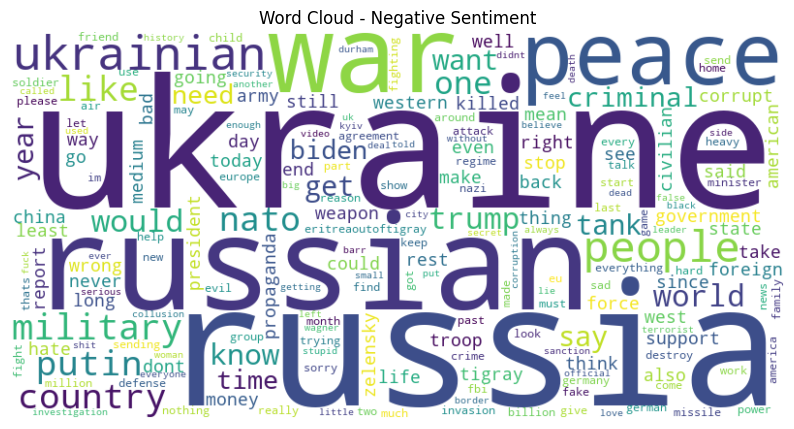

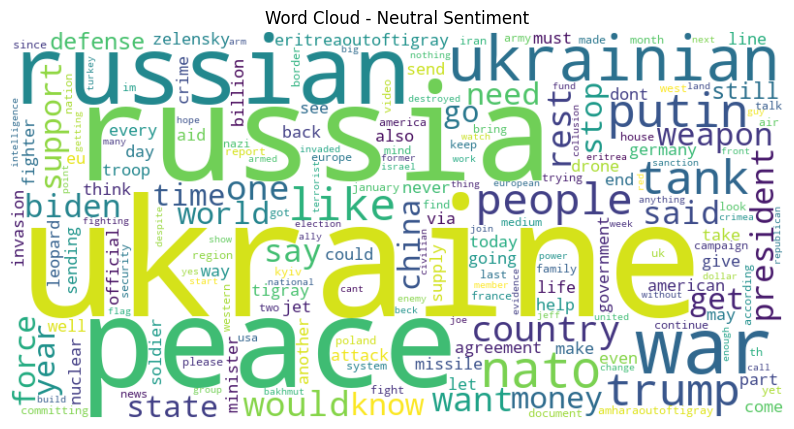

In [17]:
# Function to generate word cloud for a given dataset
def generate_word_cloud(data, title):
    vectorizer = CountVectorizer()
    dtm = vectorizer.fit_transform(data['cleaned_text'])
    vocabulary = vectorizer.get_feature_names_out()
    word_frequencies = np.asarray(dtm.sum(axis=0)).ravel()
    word_freq_df = pd.DataFrame({'Word': vocabulary, 'Frequency': word_frequencies})
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
    word_freq_dict = dict(zip(word_freq_df['Word'], word_freq_df['Frequency']))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Separate the data into three subsets based on sentiment
positive_data = data_filtered[data_filtered['Sentiment'] == 'positive']
negative_data = data_filtered[data_filtered['Sentiment'] == 'negative']
neutral_data = data_filtered[data_filtered['Sentiment'] == 'neutral']

# Generate word cloud for positive sentiment
generate_word_cloud(positive_data, 'Word Cloud - Positive Sentiment')

# Generate word cloud for negative sentiment
generate_word_cloud(negative_data, 'Word Cloud - Negative Sentiment')

# Generate word cloud for neutral sentiment
generate_word_cloud(neutral_data, 'Word Cloud - Neutral Sentiment')


# Model Building

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# NAIVE BAYES

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

In [20]:
#Preprocess the Text Data for Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_filtered['cleaned_text'])
y = data_filtered['Sentiment']


In [21]:
#Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#Implement Naive Bayes Model
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

MultinomialNB()

In [23]:
#Evaluate Naive Bayes Model
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_score_nb = f1_score(y_test, y_pred_nb, average='macro')
precision_nb = precision_score(y_test, y_pred_nb, average='macro')
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Calculate metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_score_nb = f1_score(y_test, y_pred_nb, average='macro')
precision_nb = precision_score(y_test, y_pred_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_nb, average='macro')
classification_rep = classification_report(y_test, y_pred_nb)

# Print the results
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Naive Bayes F1 Score: {f1_score_nb:.4f}")
print(f"Naive Bayes Precision: {precision_nb:.4f}")
print(f"Naive Bayes Recall: {recall_nb:.4f}")
print("Classification Report:\n", classification_rep)





Naive Bayes Accuracy: 0.8277
Naive Bayes F1 Score: 0.8239
Naive Bayes Precision: 0.8363
Naive Bayes Recall: 0.8240
Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.85      0.80     15033
     neutral       0.95      0.73      0.82     19806
    positive       0.80      0.90      0.85     24322

    accuracy                           0.83     59161
   macro avg       0.84      0.82      0.82     59161
weighted avg       0.84      0.83      0.83     59161



## Results Visualization

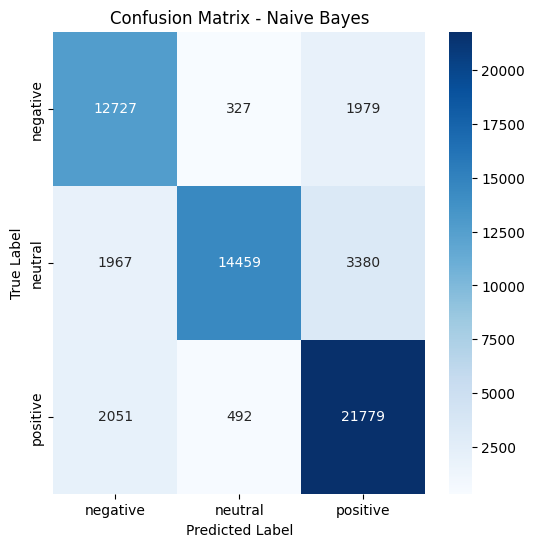

In [25]:
# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_nb, annot=True, cmap='Blues', fmt='d', xticklabels=model_nb.classes_, yticklabels=model_nb.classes_)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# LSTM

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Clear TensorFlow session
tf.keras.backend.clear_session() # Clear the TensorFlow session to free up resources and avoid potential conflicts

In [27]:
X = data_filtered['cleaned_text']
Y = data_filtered['Sentiment']
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = to_categorical(Y)

In [28]:
# Preprocess the Text Data for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_filtered['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data_filtered['cleaned_text'])
max_seq_length = 100 
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)

In [29]:
# Split Data into Training and Testing Sets
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, Y, test_size=0.2, random_state=42)

In [30]:
# Implement LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_seq_length))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9151400   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 9,193,835
Trainable params: 9,193,835
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Train LSTM model
history_lstm = model_lstm.fit(X_train, Y_train, batch_size=64, epochs=20, steps_per_epoch = 150, validation_data=(X_test, Y_test))


Epoch 1/20
150/150 [==============================] - 46s 283ms/step - loss: 0.8742 - accuracy: 0.5944 - val_loss: 0.5810 - val_accuracy: 0.7717
Epoch 2/20
150/150 [==============================] - 45s 300ms/step - loss: 0.4294 - accuracy: 0.8438 - val_loss: 0.3045 - val_accuracy: 0.8928
Epoch 3/20
150/150 [==============================] - 46s 311ms/step - loss: 0.2673 - accuracy: 0.9095 - val_loss: 0.2289 - val_accuracy: 0.9246
Epoch 4/20
150/150 [==============================] - 44s 294ms/step - loss: 0.2157 - accuracy: 0.9323 - val_loss: 0.1879 - val_accuracy: 0.9406
Epoch 5/20
150/150 [==============================] - 50s 335ms/step - loss: 0.1808 - accuracy: 0.9421 - val_loss: 0.1566 - val_accuracy: 0.9513
Epoch 6/20
150/150 [==============================] - 43s 287ms/step - loss: 0.1616 - accuracy: 0.9521 - val_loss: 0.1431 - val_accuracy: 0.9567
Epoch 7/20
150/150 [==============================] - 43s 289ms/step - loss: 0.1501 - accuracy: 0.9527 - val_loss: 0.1315 - val_ac

## Results Visualization

1849/1849 [==============================] - 24s 13ms/step


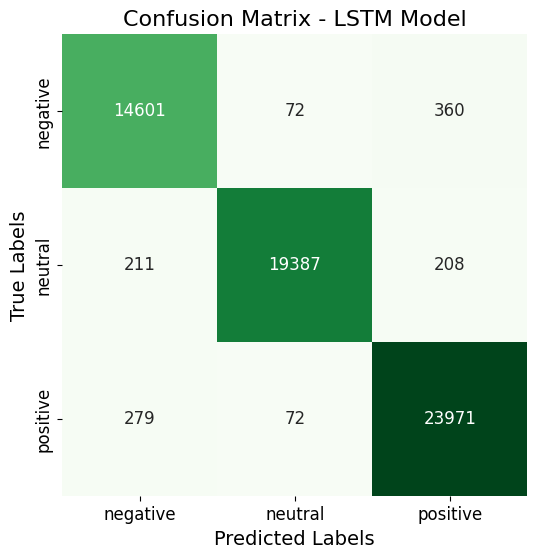

In [32]:
# Make predictions on test data
y_pred = model_lstm.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix - LSTM Model", fontsize=16)
plt.xticks(np.arange(3) + 0.5, label_encoder.classes_, fontsize=12)
plt.yticks(np.arange(3) + 0.5, label_encoder.classes_, fontsize=12)
plt.show()


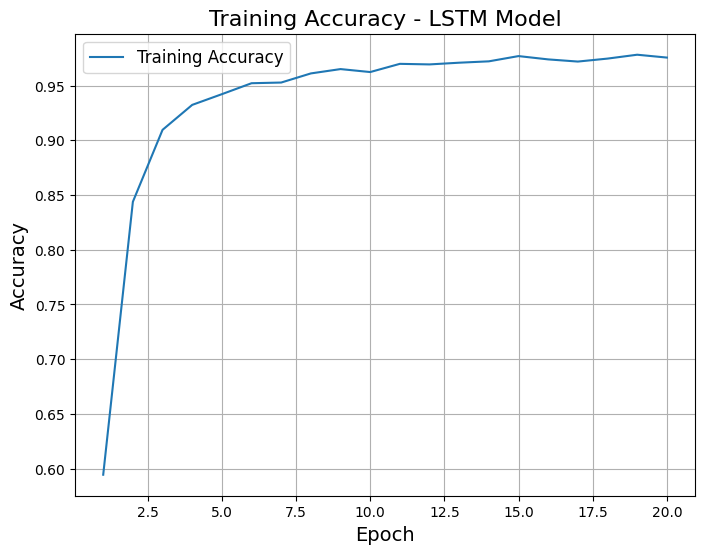

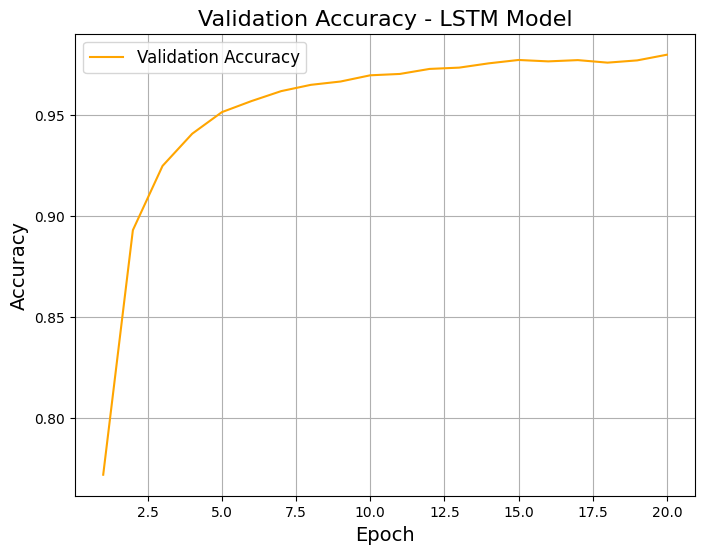

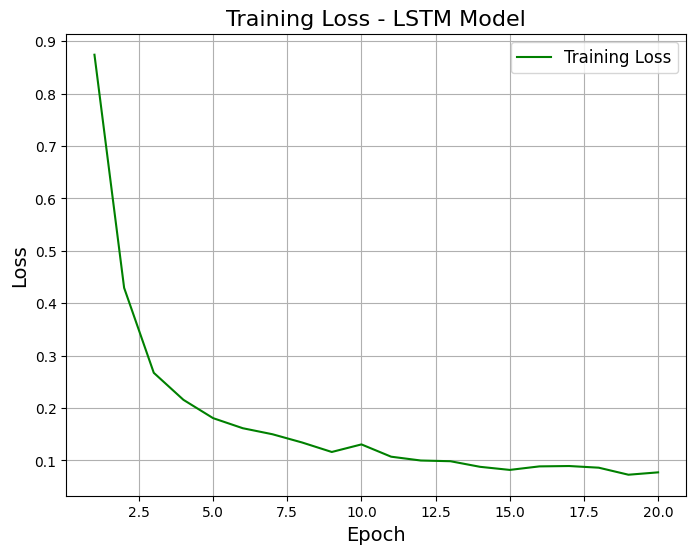

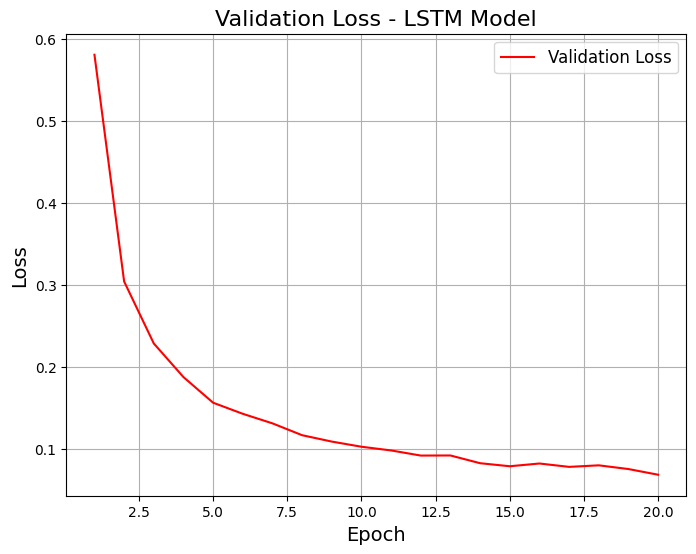

In [33]:
# Get training and validation accuracy from the history object
train_accuracy = history_lstm.history['accuracy']
val_accuracy = history_lstm.history['val_accuracy']

# Get training and validation loss from the history object
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Plot training accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy - LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy - LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='green')
plt.title('Training Loss - LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red')
plt.title('Validation Loss - LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


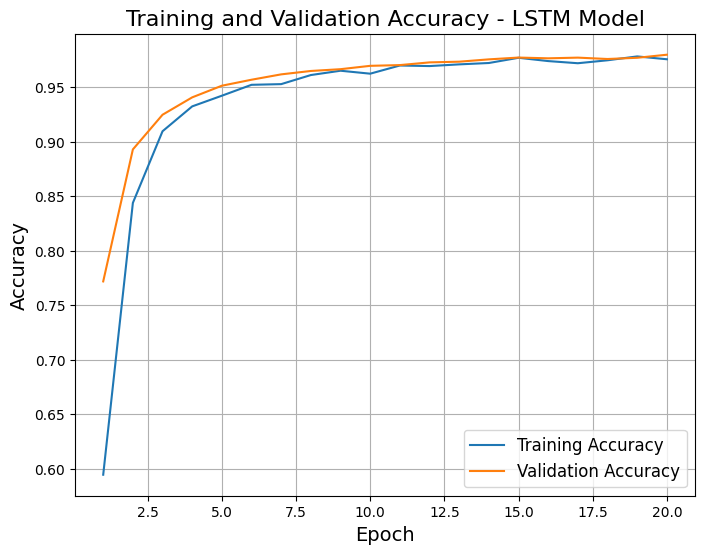

In [34]:
# Get training and validation accuracy from the history object
train_accuracy = history_lstm.history['accuracy']
val_accuracy = history_lstm.history['val_accuracy']

# Plot the accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


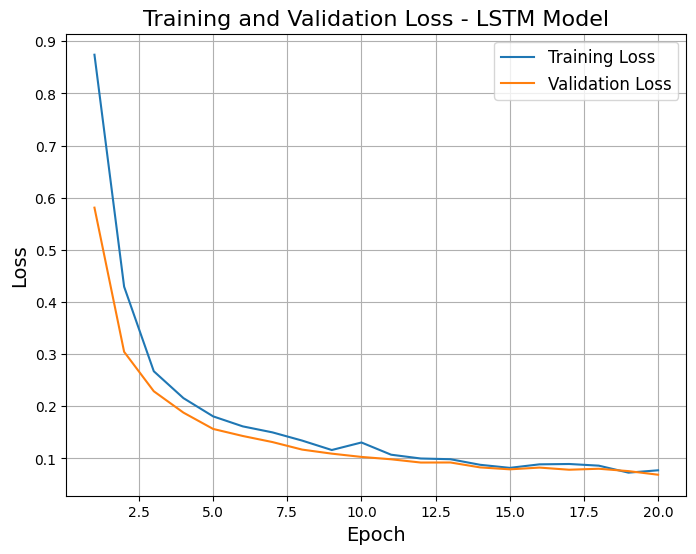

In [35]:
# Get training and validation loss from the history object
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Plot the loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss - LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Evaluation Metrics

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions using the trained LSTM model
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original labels for y_test
y_test_classes = np.argmax(Y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy:', accuracy)

# Calculate precision
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print('Precision:', precision)

# Calculate recall
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print('Recall:', recall)

# Calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('F1 Score:', f1)



1849/1849 [==============================] - 24s 13ms/step
Accuracy: 0.9796825611467014
Precision: 0.9797650235337796
Recall: 0.9796825611467014
F1 Score: 0.9796987945524698


# Bi LSTM

In [37]:
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

In [38]:
#Preprocess the Text Data for Bi-LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_filtered['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data_filtered['cleaned_text'])
max_seq_length = 100  # You can adjust this based on your data and model requirements
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)

In [39]:
#Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, Y, test_size=0.2, random_state=42)

In [40]:
# Clear TensorFlow session
tf.keras.backend.clear_session() # Clear the TensorFlow session to free up resources and avoid potential conflicts

In [41]:
#Implement Bi-LSTM Model
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_seq_length))
model_bilstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(3, activation='softmax'))
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9151400   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 9,236,267
Trainable params: 9,236,267
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Train Bi-LSTM model  Y_test))
history_bilstm = model_bilstm.fit(X_train, Y_train, batch_size=64, epochs=20, steps_per_epoch = 150, validation_data=(X_test, Y_test))

Epoch 1/20
150/150 [==============================] - 122s 773ms/step - loss: 0.8896 - accuracy: 0.5713 - val_loss: 0.5825 - val_accuracy: 0.7801
Epoch 2/20
150/150 [==============================] - 116s 772ms/step - loss: 0.4347 - accuracy: 0.8391 - val_loss: 0.3155 - val_accuracy: 0.8877
Epoch 3/20
150/150 [==============================] - 114s 763ms/step - loss: 0.2733 - accuracy: 0.9035 - val_loss: 0.2373 - val_accuracy: 0.9226
Epoch 4/20
150/150 [==============================] - 204s 1s/step - loss: 0.2151 - accuracy: 0.9315 - val_loss: 0.1805 - val_accuracy: 0.9425
Epoch 5/20
150/150 [==============================] - 237s 2s/step - loss: 0.1768 - accuracy: 0.9447 - val_loss: 0.1510 - val_accuracy: 0.9539
Epoch 6/20
150/150 [==============================] - 236s 2s/step - loss: 0.1502 - accuracy: 0.9555 - val_loss: 0.1372 - val_accuracy: 0.9600
Epoch 7/20
150/150 [==============================] - 235s 2s/step - loss: 0.1426 - accuracy: 0.9591 - val_loss: 0.1220 - val_accurac

## Results Visualization

1849/1849 [==============================] - 64s 34ms/step


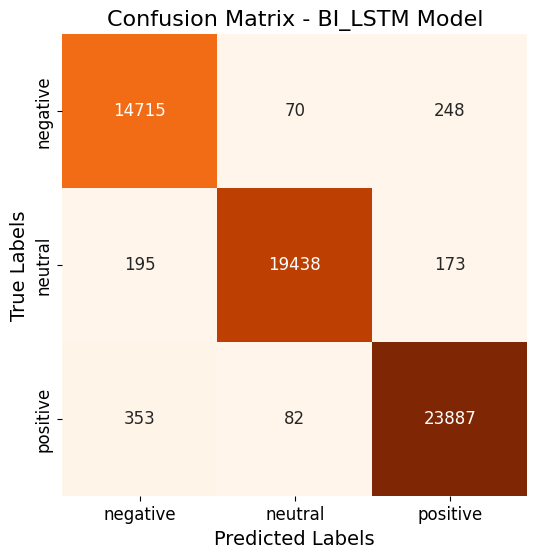

In [43]:
# Make predictions on test data
y_pred = model_bilstm.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix - BI_LSTM Model", fontsize=16)
plt.xticks(np.arange(3) + 0.5, label_encoder.classes_, fontsize=12)
plt.yticks(np.arange(3) + 0.5, label_encoder.classes_, fontsize=12)
plt.show()

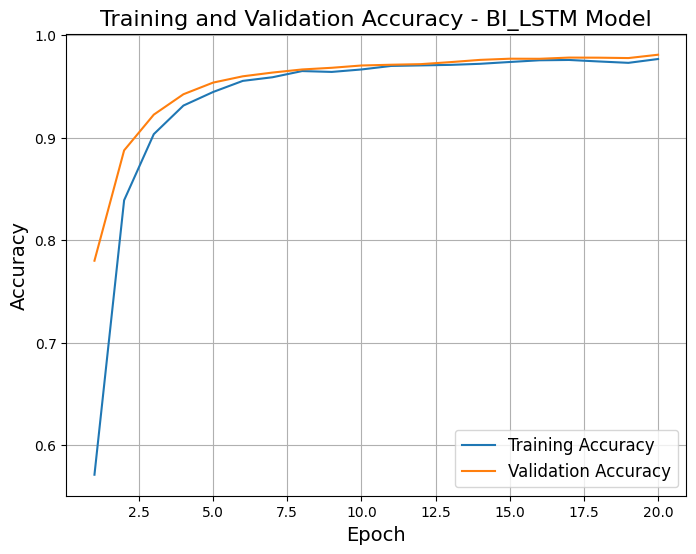

In [44]:
# Get training and validation accuracy from the history object
train_accuracy = history_bilstm.history['accuracy']
val_accuracy = history_bilstm.history['val_accuracy']

# Plot the accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy - BI_LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


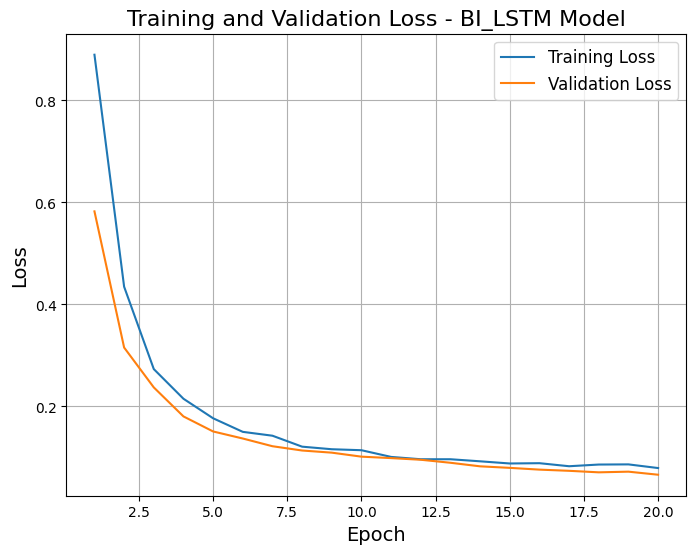

In [45]:
# Get training and validation loss from the history object
train_loss = history_bilstm.history['loss']
val_loss = history_bilstm.history['val_loss']

# Plot the loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss - BI_LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

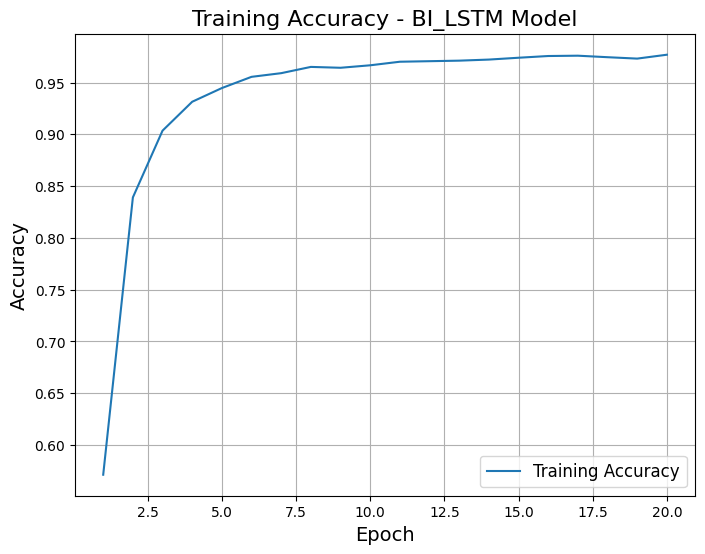

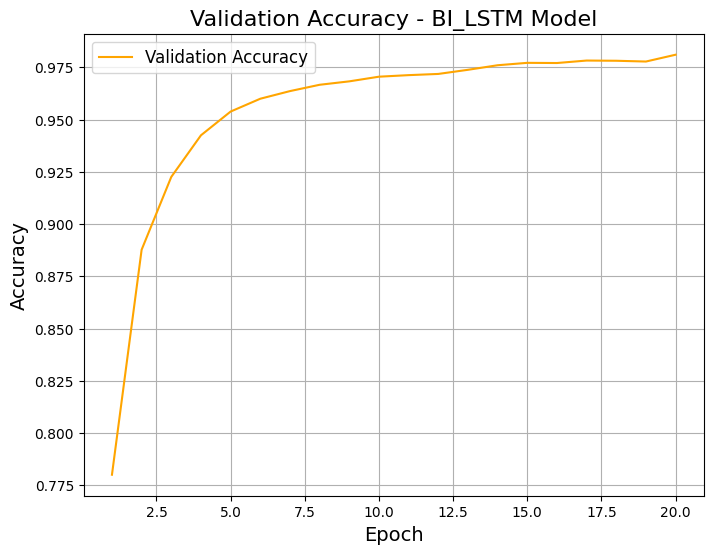

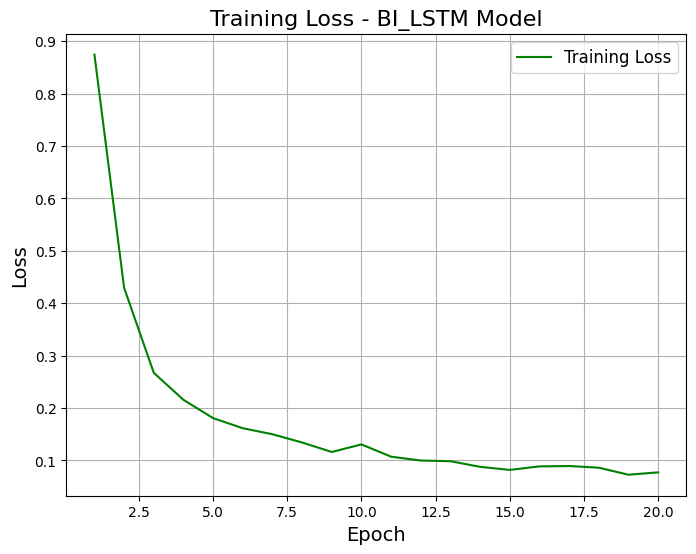

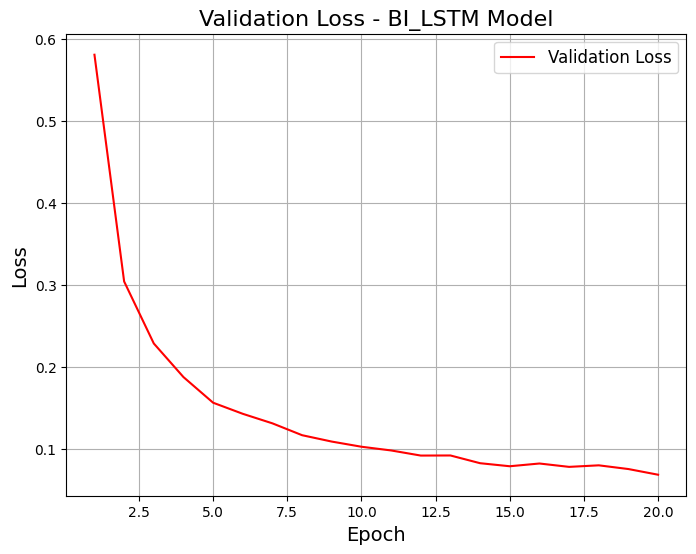

In [46]:
# Get training and validation accuracy from the history object
train_accuracy = history_bilstm.history['accuracy']
val_accuracy = history_bilstm.history['val_accuracy']

# Get training and validation loss from the history object
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Plot training accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy - BI_LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy - BI_LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='green')
plt.title('Training Loss - BI_LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red')
plt.title('Validation Loss - BI_LSTM Model', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


## Evaluation metrics

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions using the trained LSTM model
y_pred = model_bilstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to original labels for y_test
y_test_classes = np.argmax(Y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy:', accuracy)

# Calculate precision
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
print('Precision:', precision)

# Calculate recall
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
print('Recall:', recall)

# Calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('F1 Score:', f1)


1849/1849 [==============================] - 60s 33ms/step
Accuracy: 0.9810517063606092
Precision: 0.9811588622537569
Recall: 0.9810517063606092
F1 Score: 0.9810810921228882
